In [1]:
# data handling
import pandas as pd
import numpy as np

# viz
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

# model
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from imblearn.over_sampling import RandomOverSampler

# stats
from statistics import mean
from numpy.ma.core import count

# file management (Include this block only if running on Google Colab)
# from google.colab import files
# import io

In [ ]:
# File upload for Google Colab ONLY
# uploaded = files.upload()

Saving final_pred_data.csv to final_pred_data.csv


In [ ]:
# For Google Colab ONLY
# df = pd.read_csv(io.BytesIO(uploaded['final_pred_data.csv']))

In [2]:
# Normal CSV read
df = pd.read_csv('../../Datasets/final_pred_data.csv')

In [3]:
# View shape of the dataset
df.shape

(380, 12)

In [4]:
df.head()

,matchID,home,away,home_elo,away_elo,home_xG,home_xA,away_xG,away_xA,home_goals,away_goals,outcome
0,1,Manchester United,Burnley,1922.345825,1716.901733,1.181875,0.8,0.746279,0.4,1,0,Home Win
1,2,Aston Villa,Manchester City,1731.870361,2014.916016,0.725715,0.5,3.514548,2.2,0,2,Away Win
2,3,Crystal Palace,Southampton,1694.026489,1706.798462,0.692866,0.7,0.946968,0.6,1,0,Home Win
3,4,Fulham,Arsenal,1633.599243,1857.283325,0.206295,0.1,2.050351,1.0,0,3,Away Win
4,5,Liverpool,Leeds United,1933.287354,1775.257202,1.908688,1.5,0.443968,0.3,4,3,Home Win


#### Pre-processing

In [5]:
# Label encdoing for targets

# define encoder
encoder = LabelEncoder()

df['outcome'] = encoder.fit_transform(df['outcome'])

df.head()

,matchID,home,away,home_elo,away_elo,home_xG,home_xA,away_xG,away_xA,home_goals,away_goals,outcome
0,1,Manchester United,Burnley,1922.345825,1716.901733,1.181875,0.8,0.746279,0.4,1,0,2
1,2,Aston Villa,Manchester City,1731.870361,2014.916016,0.725715,0.5,3.514548,2.2,0,2,0
2,3,Crystal Palace,Southampton,1694.026489,1706.798462,0.692866,0.7,0.946968,0.6,1,0,2
3,4,Fulham,Arsenal,1633.599243,1857.283325,0.206295,0.1,2.050351,1.0,0,3,0
4,5,Liverpool,Leeds United,1933.287354,1775.257202,1.908688,1.5,0.443968,0.3,4,3,2


In [6]:
# 0 - Away Win | 1 - Draw | 2- Home Win
print(len(df.loc[df['outcome'] == 0]))
print(len(df.loc[df['outcome'] == 1]))
print(len(df.loc[df['outcome'] == 2]))

144
83
153


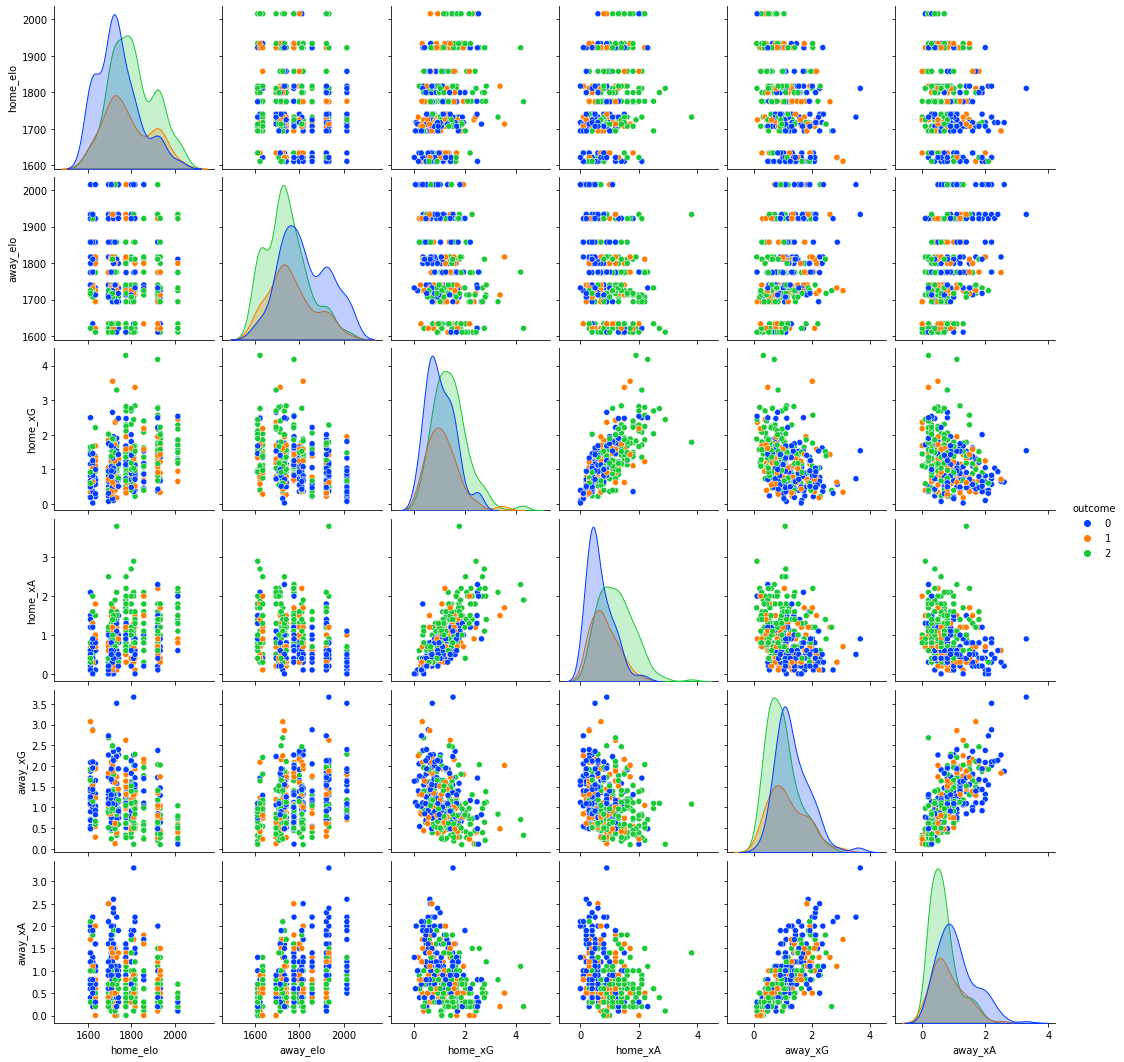

In [ ]:
# Show target data distribtuion based on features
df_plot = df.drop(['matchID','home','away','home_goals','away_goals'], axis=1)
sns.pairplot(df_plot, hue="outcome",palette="bright")

In [7]:
#Shuffle dataset
df = df.sample(frac = 1)

# define features and labels
X = df[['home_elo', 'away_elo', 'home_xG','home_xA','away_xG','away_xA']]
y = df['outcome']

In [8]:
y.value_counts()

2    153
0    144
1     83
Name: outcome, dtype: int64

In [9]:
# Over sampling to create balanced data set
ros = RandomOverSampler(random_state=42)
variablex_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', count(y))
print('Resample dataset shape', count(y_ros))

Original dataset shape 380
Resample dataset shape 459


In [10]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(variablex_ros, y_ros, test_size=0.2, random_state=42)
# Check the number of records in training and testing dataset.
print(f'The training dataset has {len(X_train)} records.')
print(f'The testing dataset has {len(X_test)} records.')

The training dataset has 367 records.
The testing dataset has 92 records.


In [11]:
# Initiate scaler
sc = StandardScaler()
# Standardize the training dataset
X_train_norm = pd.DataFrame(sc.fit_transform(X_train),index=X_train.index, columns=X_train.columns)
# Standardized the testing dataset
X_test_norm = pd.DataFrame(sc.transform(X_test),index=X_test.index, columns=X_test.columns)
# Summary statistics after standardization
X_train_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
home_elo,367.0,-1.269647e-15,1.001365,-1.583068,-0.597300,-0.004422,0.407439,2.322586
away_elo,367.0,-1.840490e-15,1.001365,-1.574671,-0.614978,-0.358772,0.554161,2.227671
home_xG,367.0,-2.807321e-16,1.001365,-1.723275,-0.727813,-0.165183,0.540464,4.564113
home_xA,367.0,-2.789171e-16,1.001365,-1.571623,-0.866506,-0.161389,0.543728,5.126987
away_xG,367.0,9.680419e-18,1.001365,-1.829638,-0.721332,-0.155212,0.695205,3.361995
away_xA,367.0,-1.839280e-16,1.001365,-1.571868,-0.646201,-0.275934,0.464599,3.241599


### SVM rbf Kernel Implementation

In [12]:
# Check default values
svc = SVC()
params = svc.get_params()
params_df = pd.DataFrame(params, index=[0])
params_df.T

,0
C,1.0
break_ties,False
cache_size,200
class_weight,None
coef0,0.0
decision_function_shape,ovr
degree,3
gamma,scale
kernel,rbf
max_iter,-1


In [13]:
# Define hyperparameter search space

# List of C values
C_range = [0.01,0.1,1,10,100]
print(f'The list of values for C are {C_range}')
# List of gamma values
gamma_range = [0.01,0.1,0.5,1,2]
print(f'The list of values for gamma are {gamma_range}')

The list of values for C are [0.01, 0.1, 1, 10, 100]
The list of values for gamma are [0.01, 0.1, 0.5, 1, 2]


In [14]:
# Assign hyperparameter search space into a grid
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type: rbf
    "kernel": ['rbf'],
    # Gamma is the Kernel coefficient for rbf
    "gamma": gamma_range
    }
# Set up score
scoring = ['accuracy','f1_macro']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [15]:
# Hyperparameter tuning with grid search CV

# Define grid search
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train_norm, y_train)

svm_pred=grid_search.predict(X_test_norm)

# Print grid search summary
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 0.5, 1, 2], 'kernel': ['rbf']},
             refit='accuracy', scoring=['accuracy', 'f1_macro'])

In [16]:
# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset: {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters: {grid_result.best_params_}')
# Print the scores for the testing dataset
print(f'Accuracy on the testing dataset: {grid_search.score(X_test_norm, y_test):.4f}')
print('F1 Score on the testing dataset: {:.4f}' .format(metrics.f1_score(y_test,svm_pred, average='weighted')))

The best accuracy score for the training dataset: 0.6211
The best hyperparameters: {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}
Accuracy on the testing dataset: 0.5761
F1 Score on the testing dataset: 0.5702


Confusion Matrix
 [[16  9  9]
 [ 6 17 10]
 [ 3  2 20]]


[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

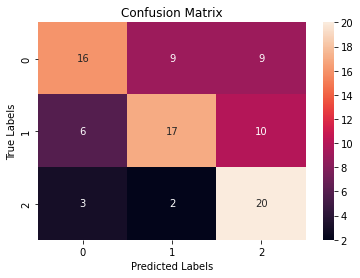

In [17]:
# Plot Confusion Matrix
labels = [0,1,2]
cm = confusion_matrix(y_test, svm_pred) #add 'labels' in the '()' for older version of sklearn
print("Confusion Matrix\n", cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])


### SVM Polynomial Kernel Implementation

In [18]:
# List of polynomial degree/q values
degree_range = [2,4,6,8]
print(f'The list of values for polynomial degree are {degree_range}')
# List of C values
C_range = [0.01,0.1,1,10,100]
print(f'The list of values for C are {C_range}')
# List of gamma values
gamma_range = [0.01,0.1,0.5,1,2]
print(f'The list of values for gamma are {gamma_range}')

The list of values for polynomial degree are [2, 4, 6, 8]
The list of values for C are [0.01, 0.1, 1, 10, 100]
The list of values for gamma are [0.01, 0.1, 0.5, 1, 2]


In [19]:
# Define the search space
param_grid = { 
    # Polynomial degree
    "degree": degree_range,
    # Regularization parameter.
    "C": C_range,
    # Kernel type: polynomial
    "kernel": ['poly'],
    # Gamma is the Kernel coefficient for poly
    "gamma": gamma_range
    }
# Set up score
scoring = ['accuracy','f1_macro']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [20]:
# Define grid search
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train_norm, y_train)

svm_pred=grid_search.predict(X_test_norm)

# Print grid search summary
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 4, 6, 8],
                         'gamma': [0.01, 0.1, 0.5, 1, 2], 'kernel': ['poly']},
             refit='accuracy', scoring=['accuracy', 'f1_macro'])

In [21]:
# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset: {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters: {grid_result.best_params_}')
# Print the scores for the testing dataset
print(f'Accuracy on the testing dataset: {grid_search.score(X_test_norm, y_test):.4f}')
print('F1 Score on the testing dataset: {:.4f}' .format(metrics.f1_score(y_test,svm_pred, average='weighted')))

The best accuracy score for the training dataset: 0.5640
The best hyperparameters: {'C': 0.1, 'degree': 4, 'gamma': 2, 'kernel': 'poly'}
Accuracy on the testing dataset: 0.5761
F1 Score on the testing dataset: 0.5732


Confusion Matrix
 [[18  7  9]
 [ 6 25  2]
 [13  2 10]]


[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

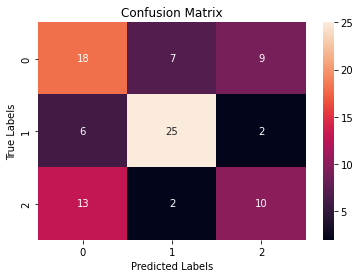

In [22]:
# Plot Confusion Matrix
labels = [0,1,2]
cm = confusion_matrix(y_test, svm_pred) #add 'labels' in the '()' for older version of sklearn
print("Confusion Matrix\n", cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])

#### Feature Engineering

In [23]:
# Observe correlation between features
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  This is separate from the ipykernel package so we can avoid doing imports until


,home_elo,away_elo,home_xG,home_xA,away_xG,away_xA
home_elo,1.00,-0.05,0.26,0.32,-0.33,-0.27
away_elo,-0.05,1.00,-0.30,-0.24,0.32,0.38
home_xG,0.26,-0.30,1.00,0.71,-0.33,-0.30
home_xA,0.32,-0.24,0.71,1.00,-0.27,-0.29
away_xG,-0.33,0.32,-0.33,-0.27,1.00,0.72
away_xA,-0.27,0.38,-0.30,-0.29,0.72,1.00


In [24]:
# PCA Visualization, Number of components = 2
pca = PCA(n_components=2)
components = pca.fit_transform(X_train_norm)

fig = px.scatter(components, x=0, y=1, color=y_train)
fig.show()

In [25]:
# PCA Visualization, Number of components = 3
pca = PCA(n_components=3)
components = pca.fit_transform(X_train_norm)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=y_train,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [26]:
# Dimensionality Reduction

# PCA implementation
pca = PCA(n_components=3)

X_train_transformed = pca.fit_transform(X_train_norm)
X_test_transformed = pca.transform(X_test_norm)

In [27]:
# Find the explained variance between each principal component
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.43494798, 0.19429587, 0.15916062])

In [28]:
# Define the search space
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    # Kernel type: rbf
    "kernel": ['rbf'],
    # Gamma is the Kernel coefficient for rbf
    "gamma": gamma_range
    }
# Set up score
scoring = ['accuracy','f1_macro']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [29]:
# Define grid search
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', # refit based on accuracy
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train_transformed, y_train)

svm_pred=grid_search.predict(X_test_transformed)

# Print grid search summary
grid_result

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=0, shuffle=True),
             estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': [0.01, 0.1, 0.5, 1, 2], 'kernel': ['rbf']},
             refit='accuracy', scoring=['accuracy', 'f1_macro'])

In [30]:
# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset: {grid_result.best_score_:.4f}')
# Print the hyperparameters for the best score
print(f'The best hyperparameters: {grid_result.best_params_}')
# Print the scores for the testing dataset
print(f'Accuracy on the testing dataset: {grid_search.score(X_test_transformed, y_test):.4f}')
print('F1 Score on the testing dataset: {:.4f}' .format(metrics.f1_score(y_test,svm_pred, average='weighted')))

The best accuracy score for the training dataset: 0.5746
The best hyperparameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Accuracy on the testing dataset: 0.6522
F1 Score on the testing dataset: 0.6546


Confusion Matrix
 [[19  7  8]
 [ 0 25  8]
 [ 5  4 16]]


[Text(0, 0.5, '0'), Text(0, 1.5, '1'), Text(0, 2.5, '2')]

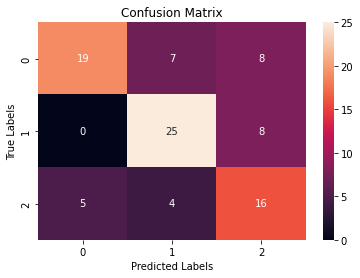

In [31]:
# Plot Confusion Matrix
labels = [0,1,2]
cm = confusion_matrix(y_test, svm_pred) #add 'labels' in the '()' for older version of sklearn
print("Confusion Matrix\n", cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels([0,1,2])
ax.yaxis.set_ticklabels([0,1,2])